In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

import time

from typing import Tuple, Union, List, Dict
from pathlib import Path

from tqdm import tqdm

# DEVICE = "mps" if torch.backends.mps.is_available() else "cpu" # MPS give an error
DEVICE = "cpu"

In [2]:
tabular_data = pd.read_csv('./data/train.csv')

In [12]:
list(sorted(tabular_data['label'].unique()))

['CE', 'LAA']

## Dataset & DataLoader

In [2]:
class MayoClinicDataset(Dataset):
    def __init__(self, csv_file:Union[str, pd.DataFrame], root_dir:str, transform:transforms.Compose=None) -> None:
        super().__init__()
        self.tabular_data = pd.read_csv(csv_file) if isinstance(csv_file, str) else csv_file
        self.root_dir = root_dir
        self.transform = transform
        
        self.train = 'label' in self.tabular_data.columns
        self.classes, self.class_to_idx = self._find_classes(self.tabular_data) if self.train else (['CE', 'LAA'], {'CE':0, 'LAA':1})
    
    def __len__(self) -> int:
        return len(self.tabular_data)
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        img_path = os.path.join(self.root_dir, self.tabular_data['image_id'].iloc[index])
        image = Image.open(f'{img_path}.png')
        
        label = self.class_to_idx[self.tabular_data['label'].iloc[index]] if self.train else -1
        
        if self.transform:
            image = self.transform(image)
            
        return (image, label)
    
    def _find_classes(self, tabular_data:pd.DataFrame) -> Tuple[List[str], Dict[str, int]]:
        classes = list(sorted(tabular_data['label'].unique()))
        class_to_idx = {classes[i]:i for i in range(len(classes))}
        
        return classes, class_to_idx
    

In [3]:
def create_weigthed_random_sampler(
    dataset:Union[MayoClinicDataset, pd.DataFrame], 
    sample_weights:List[float]=None
) -> WeightedRandomSampler:
    """Creates WeightedRandomSampler to give same importance to all the classes in the dataset.

    Args:
        dataset (Union[MayoClinicDataset, pd.DataFrame]): MayoClinicDataset dataset or pandas.DataFrame to create one.
        sample_weights (List[float], optional): Weights to give to every example. 
        If None then weights are calculated in order to give the same importance to all the classes in the dataset.
        Defaults to None.

    Returns:
        WeightedRandomSampler: Sampler
    """
    if isinstance(dataset, pd.DataFrame):
        dataset = MayoClinicDataset(
            csv_file=dataset,
            root_dir='./data/images/',
            transform=None
        )
    
    if not sample_weights:
        class_appearances = dataset.tabular_data['label'].value_counts()
        class_weights = list(1/class_appearances)
        
        sample_weights = [class_weights[label] for (data, label) in dataset]
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    

def create_dataloader(
    tabular_data:List[pd.DataFrame],
    img_root_dir:str,
    transforms:List[transforms.Compose],
    batch_size:int=1,
    train_shuffle:bool=True,
    train_sampler:torch.utils.data.Sampler=None,
    num_workers:int=0
) -> Tuple[Tuple[torch.utils.data.DataLoader], List[str]]:
    """
    Creates Dataloaders for each tabular dataframe given, based on MayoClinicDataset. 
    It assumes the first dataframe given in the list is the train dataset.

    Args:
        tabular_data (List[pd.DataFrame]): List with the tabular data.
        img_root_dir (str): Path to the image folder.
        transforms (List[transforms.Compose]): List of transforms.Compose to indicate which tranformation to apply 
        to each dataframe.
        batch_size (int, optional): Number of samples per batch in each of the DataLoaders. Defaults to 1.
        train_shuffle (bool, optional): Whether or not to shuffle train data. Defaults to False.
        train_sampler (torch.data.utils.Sampler, optional): Sampler to be used for train Dataloader. Defaults to None.
        num_workers (int, optional): Number of workers (cpu's). Defaults to 0.

    Returns:
        Tuple[Tuple[torch.utils.data.DataLoader], List[str]]: Returns a Tuple with the same amount of DataLoaders 
        as the Tabular Data that was given, as well as and List with the target classes.
    """
    assert len(tabular_data) == len(transforms), \
        "Number of tabular data, must be the same as the number of transformation objects."
                                                    
    train_shuffle = False if train_sampler else train_shuffle
                                                    
    datasets = [MayoClinicDataset(data, img_root_dir, transform) for data, transform in zip(tabular_data, transforms)]
    
    dataloaders = []
    
    for i, dataset in enumerate(datasets):
        if i == 0: # Train Dataser => create train DataLoader
            dataloaders.append(
                DataLoader(
                    dataset=dataset,
                    batch_size=batch_size,
                    shuffle=train_shuffle,
                    sampler=train_sampler,
                    num_workers=num_workers,
                )
            )
        else:
            dataloaders.append(
                DataLoader(
                    dataset=dataset,
                    batch_size=batch_size,
                    shuffle=False,
                    sampler=None,
                    num_workers=num_workers,
                )
            )
            
    return dataloaders, datasets[0].classes


## Create model

In [4]:
def create_efficientnet_b0_model():
    weights = models.EfficientNet_B0_Weights.DEFAULT
    model = models.efficientnet_b0(weights=weights)
    
    for param in model.features.parameters():
            param.requires_grad = False
    
    #model.classifier = nn.Sequential(
    #    nn.Linear(in_features=1280, out_features=16, bias=True),
    #    nn.ReLU(),
    #    nn.Dropout(p=0.40),
    #    nn.Linear(in_features=16, out_features=16, bias=True),
    #    nn.ReLU(),
    #    nn.Dropout(p=0.40),
    #    nn.Linear(in_features=16, out_features=1, bias=True),
    #)
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.50),
        nn.Linear(in_features=1280, out_features=1, bias=True)
    )
    
    return model


def create_efficientnet_b4_model():
    weights = models.EfficientNet_B4_Weights.DEFAULT
    model = models.efficientnet_b4(weights=weights)
    
    for param in model.features.parameters():
            param.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.50),
        nn.Linear(in_features=1792, out_features=1, bias=True),
    )
    
    return model


def create_efficientnet_v2_model(size):
    if size == 's' or size == 'small':
        weights = models.EfficientNet_V2_S_Weights.DEFAULT
        model = models.efficientnet_v2_s(weights=weights)
        
    if size == 'm' or size == 'medium':
        weights = models.EfficientNet_V2_M_Weights.DEFAULT
        model = models.efficientnet_v2_m(weights=weights)
        
    if size == 'l' or size == 'large':
        weights = models.EfficientNet_V2_L_Weights.DEFAULT
        model = models.efficientnet_v2_l(weights=weights)
    
    for param in model.features.parameters():
            param.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.50),
        nn.Linear(in_features=1280, out_features=1, bias=True),
    )
    
    return model


def create_convnext_model(size):
    if size == 't' or size == 'tiny':
        weights = models.ConvNeXt_Tiny_Weights.DEFAULT
        model = models.convnext_tiny(weights=weights)
        in_features = 768
        
    if size == 's' or size == 'small':
        weights = models.ConvNeXt_Small_Weights.DEFAULT
        model = models.convnext_small(weights=weights)
        in_features = 768
        
    if size == 'b' or size == 'base':
        weights = models.ConvNeXt_Base_Weights.DEFAULT
        model = models.convnext_base(weights=weights)
        in_features = 1024
        
    if size == 'l' or size == 'large':
        weights = models.ConvNeXt_Large_Weights.DEFAULT
        model = models.convnext_large(weights=weights)
        in_features = 1536
    
    for param in model.features.parameters():
            param.requires_grad = False
            
    class LayerNorm2d(nn.LayerNorm):
        def forward(self, x: torch.Tensor) -> torch.Tensor:
            x = x.permute(0, 2, 3, 1)
            x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
            x = x.permute(0, 3, 1, 2)
            return x
    
    model.classifier = nn.Sequential(
        LayerNorm2d((in_features,), eps=1e-06, elementwise_affine=True),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(in_features=in_features, out_features=1, bias=True)
    )
    
    return model

## Train model

In [5]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> Tuple[float, float, float]:
    """
    Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on.
        loss_fn: A PyTorch loss function to minimize.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        device: A target device to compute on (e.g. "cuda" or "cpu").
    
    Returns:
        Tuple[float, float, float]: Train Loss, Accuracy and AUC.
    """
    model.train()

    train_loss, train_acc, train_auc = 0, 0, 0
    targets, predictions = [], [] # To calculate AUC

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X).flatten().type(torch.float64)
        targets.append(y)
        predictions.append(y_pred)

        loss = loss_fn(y_pred, y.type(torch.float64))
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        y_pred_class = torch.round(torch.sigmoid(y_pred))
        train_acc += (y_pred_class == y).sum().item() / len(y_pred_class)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    # To calculate AUC
    targets = torch.cat(targets)
    predictions = torch.cat(predictions)
    train_auc = roc_auc_score(targets.detach().numpy(), predictions.detach().numpy())

    return train_loss, train_acc, train_auc


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
) -> Tuple[float, float, float]:
    """
    Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
        model: A PyTorch model to be tested.
        dataloader: A DataLoader instance for the model to be tested on.
        loss_fn: A PyTorch loss function to calculate loss on the test data.
        device: A target device to compute on (e.g. "cuda" or "cpu").
        
    Returns:
        Tuple[float, float, float]: Test Loss, Accuracy and AUC.
    """
    model.eval()

    test_loss, test_acc, test_auc = 0, 0, 0
    targets, predictions = [], []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X).flatten().type(torch.float64)
            targets.append(y)
            predictions.append(test_pred_logits)
            loss = loss_fn(test_pred_logits, y.type(torch.float64))
            test_loss += loss.item()

            test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    targets = torch.cat(targets)
    predictions = torch.cat(predictions)
    test_auc = roc_auc_score(targets.numpy(), predictions.numpy())

    return test_loss, test_acc, test_auc


In [6]:
def train(
    model: torch.nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    test_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device, 
    writer: torch.utils.tensorboard.writer.SummaryWriter 
) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.
    
    It uses Reduce LR On Plateau regularization based on test loss.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "train_auc": [],
        "test_loss": [],
        "test_acc": [],
        "test_auc": []
    }
    
    #scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
    
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_auc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        
        test_loss, test_acc, test_auc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )
        
        #scheduler.step(test_loss)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"train_auc: {train_auc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"test_auc: {test_auc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_auc"].append(train_auc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_auc"].append(test_auc)

        if writer:
            writer.add_scalar(tag="Loss/train", scalar_value=train_loss, global_step=epoch)
            writer.add_scalar(tag="Loss/test", scalar_value=test_loss, global_step=epoch)
            writer.add_scalar(tag="Accuracy/train", scalar_value=train_acc, global_step=epoch)
            writer.add_scalar(tag="Accuracy/test", scalar_value=test_acc, global_step=epoch)
            writer.add_scalar(tag="AUC/train", scalar_value=train_auc, global_step=epoch)
            writer.add_scalar(tag="AUC/test", scalar_value=test_auc, global_step=epoch)

            writer.close()

    return results


## Save Model

In [7]:
def save_model(
    model: torch.nn.Module,
    target_dir: str,
    model_name: str
) -> None:
    """
    Saves a PyTorch model to a target directory.

    Args:
        model: A target PyTorch model to save.
        target_dir: A directory for saving the model to.
        model_name: A filename for the saved model. Should include
        either ".pth" or ".pt" as the file extension.
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)
    
    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)
    

## Utils

In [8]:
def get_mean_and_std(
    dataloader: torch.utils.data.DataLoader,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Calculates the mean and std over every channel in the image.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Tuple with the mean, std of every image channel.
    """
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std


In [9]:
def create_writer(
    experiment_name: str, 
    model_name: str, 
    extra: str=None
) -> torch.utils.tensorboard.writer.SummaryWriter():
    """
    Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)


In [10]:
def train_val_test_split(
    csv_file:str, 
    val_split:float, 
    test_split:float
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Divides tabulat data (csv file) into train, validation and test.

    Args:
        csv_file (str): Path to csv file.
        val_split (float): Percentage of data to be used for validation.
        test_split (float): Percentage of data to be used for test.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: Train, validation, test dataframes.
    """
    assert ((test_split > 0 and test_split < 1) and (val_split > 0 and val_split < 1)), \
        "val_size and test_size have to be between 0 and 1."
        
    assert val_split + test_split < 1, "Validation and Test need to sum up to something less than 1."
    
    data = pd.read_csv(csv_file)
    nr_exaples = len(data)
    nr_val_examples = int(nr_exaples*val_split)
    nr_test_examples = int(nr_exaples*test_split)
    
    train_indices, test_indices = train_test_split(
        list(range(nr_exaples)), 
        test_size=nr_test_examples, 
        stratify=data['label'].to_numpy()
    )
    
    train_indices, val_indices = train_test_split(
        train_indices, 
        test_size=nr_val_examples, 
        stratify=data['label'].iloc[train_indices].to_numpy()
    )
    
    return data.iloc[train_indices], data.iloc[val_indices], data.iloc[test_indices]
    

## Main

In [11]:
VAL_SIZE = 0.1
TEST_SIZE = 0.1
BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 3e-3

#MODEL = "efficientnet_b0-Linear32-Relu-Dropout-Linear16-Relu-Dropout-Linear1"
MODEL = "convnext_small"
MODEL_NAME = f"convnext_small-batch_size={BATCH_SIZE}-epochs={EPOCHS}-lr={LEARNING_RATE}-{time.time()}"
MODEL_SAVE_EXTENSION = '.pt' # .pt or .pth

EXPERIMENT_NAME = f"{MODEL}"
MODEL_SAVE_DIR = "./models/"

CALC_MEAN_STD = False

In [12]:
if CALC_MEAN_STD:
    data_transform = transforms.Compose([
        transforms.Resize((512, 512)), 
        transforms.ToTensor()
    ])

    tabular_data = pd.read_csv('./data/train.csv')
    
    (train_dataloader,), classes = create_dataloader(
        tabular_data=[tabular_data],
        img_root_dir='./data/images/',
        transforms=[data_transform],
        batch_size=BATCH_SIZE
    )

    mean, std = get_mean_and_std(train_dataloader)

    print(mean)
    print(std)

In [13]:
train_tabular_data, val_tabular_data, test_tabular_data = train_val_test_split(
    csv_file='./data/train.csv', 
    val_split=VAL_SIZE, 
    test_split=TEST_SIZE
)

train_data_transform = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.9454, 0.8770, 0.8563), std=(0.1034, 0.2154, 0.2716))
])

eval_data_transform = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.9454, 0.8770, 0.8563), std=(0.1034, 0.2154, 0.2716))
])

sampler = create_weigthed_random_sampler(
    dataset=train_tabular_data
)

(train_dataloader, val_dataloader, test_dataloader), classes = create_dataloader(
    tabular_data=[train_tabular_data, val_tabular_data, test_tabular_data],
    img_root_dir='./data/images/',
    transforms=[train_data_transform, eval_data_transform, eval_data_transform],
    batch_size=BATCH_SIZE,
    train_sampler=sampler
)

model = create_convnext_model('s')

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

writer = create_writer(experiment_name=EXPERIMENT_NAME, model_name=MODEL_NAME)

results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=DEVICE,
    writer=writer,
)

save_model(
    model=model, 
    target_dir=MODEL_SAVE_DIR, 
    model_name=f'{MODEL_NAME}{MODEL_SAVE_EXTENSION}'
)

NameError: name 'gfgf' is not defined

## Test Predictions

In [ ]:
def predict(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Makes predictions for all the samples in the DataLoader.

    Args:
        model (torch.nn.Module): Trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader with data to predict (data should not be shuffled).
        device (torch.device): Device.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Predictions of the probabilities and observerd classes.
    """
    model.to(device)
    model.eval()

    ys = []
    predictions = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X).flatten().type(torch.float64)

            ys.append(y)
            predictions.append(torch.sigmoid(test_pred_logits))

    return torch.cat(predictions), torch.cat(ys)


In [ ]:
def multi_class_logarithmic_loss(y_true:List[int], y_preds:Tuple[List])->float:
    """
    Calculates the weighted multi-class logarithmic loss. 
    The code is not optimized as it assumes the weights for each class to be the same (1/nr_classes),
    however it does not take this assumpytion into consideration when calculating the loss.

    Args:
        y_true (List[int]): True values.
        y_preds (Tuple[List]): Predicted values

    Returns:
        float: Mean loss value.
    """
    loss = 0
    
    if not isinstance(y_true, (np.ndarray, np.generic)):
        y_true = np.array(y_true)
        
    if not isinstance(y_preds, (np.ndarray, np.generic)):
        y_preds = np.array(y_preds)
        
    classes, counts = np.unique(y_true, return_counts=True)
    nr_classes = len(classes)
    
    # Gives same weight to every class 1/number of class
    w = np.zeros(nr_classes) + 1/nr_classes
        
    # Normalize predictions
    y_preds = y_preds/np.expand_dims(np.sum(y_preds, axis=1), axis=-1)
    
    # Clip predicted probabilities
    y_preds = np.clip(y_preds, 10**-15, 1-10**-15)
    
    for true, preds in zip(y_true, y_preds):
        for i in range(nr_classes):
            if true != classes[i]:
                continue # When it is not the true class the value added is 0, so we ignore it
                        
            loss += -((w[i] * np.log(preds[i]) / counts[i]) / (np.sum(w)))
            
    return loss/len(y_true)


In [ ]:
def plot_ROC_Curve(fpr:List, tpr:List, auc:float, cm, ax)->None:
    """Plots ROC Curve.

    Args:
        fpr (List): False Positive Rate points.
        tpr (List): True Positive Rate points.
        auc (float): Model AUC.
        cm (_type_): Model Confusion Matrix.
        ax (_type_): Axis to plot.
    """
    tpr_score = float(cm[1][1])/(cm[1][1] + cm[1][0])
    fpr_score = float(cm[0][1])/(cm[0][0]+ cm[0][1])

    ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    ax.plot([0,1], [0,1], 'r--')
    ax.plot(fpr_score, tpr_score, marker='o', color='black')

    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    ax.legend(loc='lower right')
    
    return ax

In [ ]:
test_predictions, y_test = predict(
    model=model,
    dataloader=test_dataloader,
    device=DEVICE
)

auc = roc_auc_score(y_test.numpy(), test_predictions.numpy())
class_test_predictions = pd.DataFrame({
    'CE':1-test_predictions.numpy(),
    'LAA':test_predictions.numpy()
})
multi_class_log_loss = multi_class_logarithmic_loss(y_test.numpy(), class_test_predictions.to_numpy())


print(f'Accuracy = {torch.sum(y_test == torch.round(test_predictions).type(torch.int))/len(test_predictions)*100:.2f}')
print(f'AUC = {auc:.3f}')
print(f'Multi-class logarithmic loss = {multi_class_log_loss:.5f}')

Accuracy = 50.67
AUC = 0.593
Multi-class logarithmic loss = 0.01012


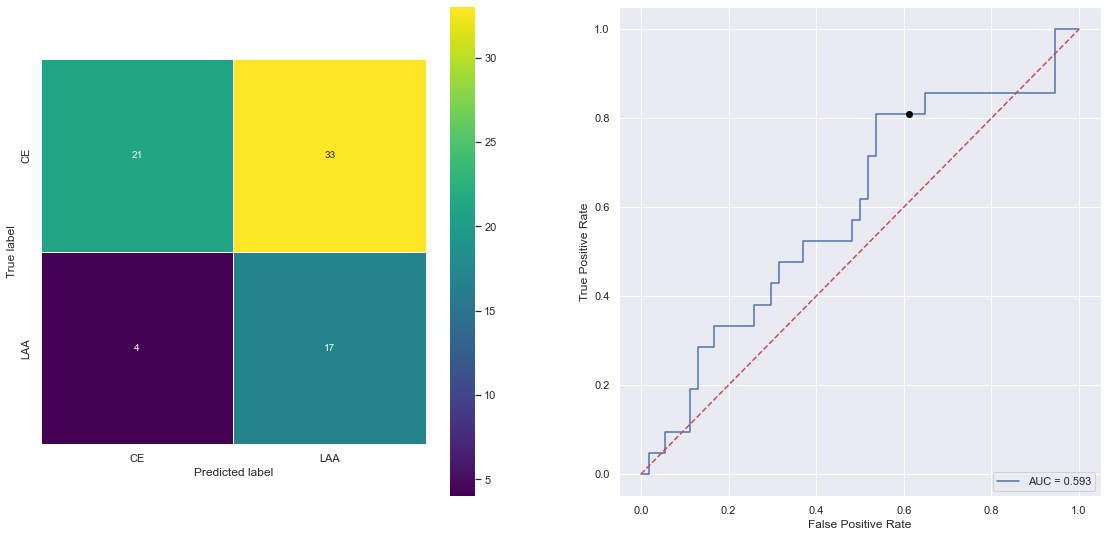

In [ ]:
cm = confusion_matrix(y_test.numpy(), torch.round(test_predictions).type(torch.int).numpy())
fpr, tpr, thresholds = roc_curve(y_test.numpy(), test_predictions.numpy())

fig, ax = plt.subplots(1, 2, figsize=(19,9))

sns.heatmap(
    cm, 
    annot=True, 
    cmap='viridis', 
    linewidths=.5, 
    square=True, 
    xticklabels=classes, 
    yticklabels=classes, 
    ax=ax[0]
)

ax[0].set_ylabel('True label')
ax[0].set_xlabel('Predicted label')

plot_ROC_Curve(fpr, tpr, auc, cm, ax[1])

plt.show()

## Test Predictions with TTA

In [ ]:
def create_TTA_dataloader(
    tabular_data:Union[str, pd.DataFrame],
    img_root_dir:str,
    base_transforms:transforms.Compose,
    aug_transforms:transforms.Compose,
    batch_size:int=1,
    num_workers:int=0
) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader, List[str]]:
    """
    Creates Dataloaders for the tabular dataframe given to be used with TTA predictions, based on MayoClinicDataset. 

    Args:
        tabular_data (Union[str, pd.DataFrame]): Path or pandas Dataframe to tabular data.
        img_root_dir (str): Path to the image folder.
        base_transforms (transforms.Compose): Compose to indicate which tranformation, without any data augmentation. 
        Ex: Resize, ToTensor,...
        aug_transforms (transforms.Compose): Compose to indicate which tranformation, with data augmentation steps.
        batch_size (int, optional): Number of samples per batch in each of the DataLoaders. Defaults to 1.
        num_workers (int, optional): Number of workers (cpu's). Defaults to 0.

    Returns:
        Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader, List[str]]: Returns a Tuple with the 
        base Dataloader, the augment Dataloader and the target classes labels
    """

    base_dataset = MayoClinicDataset(tabular_data, img_root_dir, base_transforms)
    
    classes = base_dataset.classes
    
    base_dataloader = DataLoader(
        dataset=base_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )
    
    augment_dataloader = DataLoader(
        dataset=MayoClinicDataset(tabular_data, img_root_dir, aug_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )                                        
            
    return base_dataloader, augment_dataloader, classes


In [ ]:
def predict_TTA(
    model:torch.nn.Module,
    base_dataloader:torch.utils.data.DataLoader,
    aug_dataloader:torch.utils.data.DataLoader,
    device:torch.device,
    n_aug_samples:int=4,
    beta:float=0.25,
    use_max:bool=False
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Uses Test Time Augmentation to make predictions.

    Args:
        model (torch.nn.Module): Trained model.
        base_dataloader (torch.utils.data.DataLoader): DataLoader with data to predict, without the data augmentation 
        steps (data should not be shuffled). 
        aug_dataloader (torch.utils.data.DataLoader): DataLoader with data to predict, with the data augmentation 
        steps (data should not be shuffled). 
        device (torch.device): Device.
        n_aug_samples (int, optional): Number of times to transform the data and make predictions on it. Defaults to 4.
        beta (float, optional): Importance given to prediction of augmented predictions. Defaults to 0.25.
        use_max (bool, optional): Whether or not to use maximum values for predictions. Defaults to False.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Predictions of the probabilities and observed classes.
    """
    model.to(device)
    model.eval()

    aug_predictions = []

    with tqdm(total=n_aug_samples+1) as pbar:
        predictions, targets = predict(model, base_dataloader, device)
        
        pbar.update()
        
        for _ in range(n_aug_samples):
            aug_predictions.append(predict(model, aug_dataloader, device)[0])
            pbar.update()
            
    aug_predictions = torch.stack(aug_predictions)
    aug_predictions = aug_predictions.max(0)[0] if use_max else aug_predictions.mean(0)
                
    if use_max: return targets, torch.stack([predictions, aug_predictions], 0).max(0)[0]
    predictions = torch.lerp(aug_predictions, predictions, beta)

    return predictions, targets

In [ ]:
base_test_dataloader, aug_test_dataloader, classes = create_TTA_dataloader(
    tabular_data=test_tabular_data,
    img_root_dir='./data/images/',
    base_transforms=eval_data_transform,
    aug_transforms=train_data_transform,
    batch_size=BATCH_SIZE
)

test_predictions_TTA, y_test = predict_TTA(
    model=model,
    base_dataloader=base_test_dataloader,
    aug_dataloader=aug_test_dataloader,
    device=DEVICE
)

auc_TTA = roc_auc_score(y_test.numpy(), test_predictions_TTA.numpy())
class_test_predictions_TTA = pd.DataFrame({
    'CE':1-test_predictions_TTA.numpy(),
    'LAA':test_predictions_TTA.numpy()
})
multi_class_log_loss_TTA = multi_class_logarithmic_loss(y_test.numpy(), class_test_predictions_TTA.to_numpy())


print(f'Accuracy with TTA = {torch.sum(y_test == torch.round(test_predictions_TTA).type(torch.int))/len(test_predictions_TTA)*100:.2f}')
print(f'AUC with TTA = {auc_TTA:.3f}')
print(f'Multi-class logarithmic loss with TTA = {multi_class_log_loss_TTA:.5f}')

100%|██████████| 5/5 [05:28<00:00, 65.61s/it]

Accuracy with TTA = 46.67
AUC with TTA = 0.601
Multi-class logarithmic loss with TTA = 0.00980


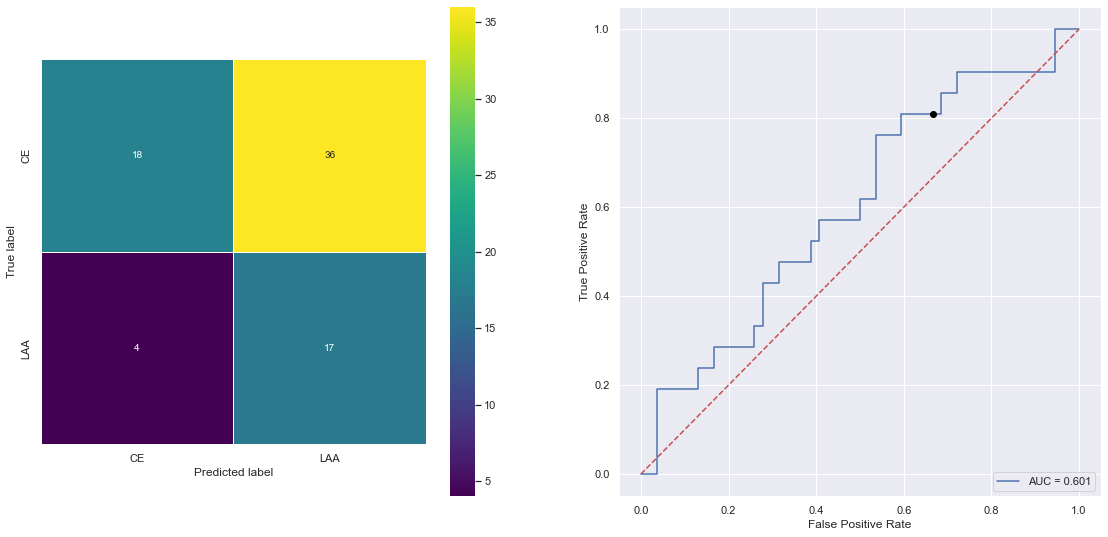

In [ ]:
cm_TTA = confusion_matrix(y_test.numpy(), torch.round(test_predictions_TTA).type(torch.int).numpy())
fpr_TTA, tpr_TTA, thresholds_TTA = roc_curve(y_test.numpy(), test_predictions_TTA.numpy())

fig, ax = plt.subplots(1, 2, figsize=(19,9))

sns.heatmap(
    cm_TTA, 
    annot=True, 
    cmap='viridis', 
    linewidths=.5, 
    square=True, 
    xticklabels=classes, 
    yticklabels=classes, 
    ax=ax[0]
)

ax[0].set_ylabel('True label')
ax[0].set_xlabel('Predicted label')

plot_ROC_Curve(fpr_TTA, tpr_TTA, auc_TTA, cm_TTA, ax[1])

plt.show()